In [1]:
!pip install -q datasets torchsummary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 6.8 MB/s eta 0:00:00


In [2]:
!pip install transformers==4.30 -q
!pip install accelerate==0.21.0 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 42.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 2.4 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import sklearn
import datetime
import time
import matplotlib.pyplot as plt

from tqdm import tqdm
from collections import Counter
from sklearn.metrics import precision_recall_fscore_support
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict

In [4]:
#add dataset
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
%cd drive/My Drive/MS thesis/Data/keyBERTproject/

Mounted at /content/drive/
/content/drive/My Drive/MS thesis/Data/keyBERTproject


In [5]:
import pandas as pd
# read the csv file
df = pd.read_csv("/content/drive/My Drive/MS thesis/Data/keyBERTproject/gender_related_dataset.csv")
len(df)

4111

In [6]:
#leave only necessary columns and merge two text columns into one
df = df[['Title', 'Post_body', 'Label']]
df['Text'] = df['Title'].fillna('') + ' ' + df['Post_body'].fillna('')
df = df.drop(columns=['Title', 'Post_body'])
df = df.rename(columns={"Text": "text", "Label": "labels"})

In [7]:
df

,labels,text
0,0,"Trying to add someone I just met, and facebook..."
1,0,"No help from Facebook Support, in stream ads f..."
2,0,How do I reset my Reels recommendations on Fac...
3,0,Is there any way to find out if anyone unfrien...
4,0,How to fix this error? I've tried to send frie...
...,...,...
4106,0,22 [M4F] Looking For Friends (And More!) Hello...
4107,0,32[M4F] looking for a Friend. 32[M4F] Married ...
4108,0,24 [M4F] Lancashire Wanting to meet women in L...
4109,0,31 [F4M] Irish female looking for new friends ...


In [8]:
train_end_point = int(df.shape[0]*0.6)
val_end_point = int(df.shape[0]*0.8)
df_train = df.iloc[:train_end_point,:]
df_val = df.iloc[train_end_point:val_end_point,:]
df_test = df.iloc[val_end_point:,:]
print(df_train.shape, df_test.shape, df_val.shape)

(2466, 2) (823, 2) (822, 2)


In [9]:
# Converting pandas DataFrames into Hugging Face Dataset objects:
dataset_train = Dataset.from_pandas(df_train)
dataset_val = Dataset.from_pandas(df_val)
dataset_test = Dataset.from_pandas(df_test)

In [10]:
# Shuffle the training dataset
dataset_train_shuffled = dataset_train.shuffle(seed=42)  # Using a seed for reproducibility

In [11]:
labels_train = dataset_train['labels']
labels_test = dataset_test['labels']

In [12]:
tokenizer = AutoTokenizer.from_pretrained("distilroberta-base")
tokenize_func = lambda sentences: tokenizer(sentences['text'], padding="max_length", truncation=True)

tok_train_ds = dataset_train.map(tokenize_func, batched=True)
tok_test_ds = dataset_test.map(tokenize_func, batched=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/2466 [00:00<?, ? examples/s]

Map:   0%|          | 0/823 [00:00<?, ? examples/s]

In [13]:
tok_val_ds = dataset_val.map(tokenize_func, batched=True)

Map:   0%|          | 0/822 [00:00<?, ? examples/s]

In [14]:
model = AutoModelForSequenceClassification.from_pretrained("distilroberta-base", num_labels=2)

model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.we

In [15]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=5,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

In [16]:
!pip show accelerate
!pip show transformers

Name: accelerate
Version: 0.21.0
Summary: Accelerate
Home-page: https://github.com/huggingface/accelerate
Author: The HuggingFace team
Author-email: sylvain@huggingface.co
License: Apache
Location: /usr/local/lib/python3.10/dist-packages
Requires: numpy, packaging, psutil, pyyaml, torch
Required-by: 
Name: transformers
Version: 4.30.0
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /usr/local/lib/python3.10/dist-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: 


In [17]:
from sklearn.metrics import accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [18]:
trainer = Trainer(
    model=model, args=training_args, train_dataset=tok_train_ds, eval_dataset=tok_test_ds, compute_metrics=compute_metrics,
)

In [19]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
10,0.661500
20,0.636500
30,0.598200
40,0.544100
50,0.418100
60,0.257800
70,0.148300
80,0.095800
90,0.145500
100,0.124100


TrainOutput(global_step=775, training_loss=0.10752913924955552, metrics={'train_runtime': 624.0642, 'train_samples_per_second': 19.758, 'train_steps_per_second': 1.242, 'total_flos': 1633323025428480.0, 'train_loss': 0.10752913924955552, 'epoch': 5.0})

In [20]:
trainer.evaluate()

{'eval_loss': 0.10978597402572632,
 'eval_accuracy': 0.9756986634264885,
 'eval_f1': 0.4444444444444444,
 'eval_precision': 0.36363636363636365,
 'eval_recall': 0.5714285714285714,
 'eval_runtime': 14.9584,
 'eval_samples_per_second': 55.019,
 'eval_steps_per_second': 3.476,
 'epoch': 5.0}

In [21]:
predictions = trainer.predict(tok_val_ds)

In [22]:
print(predictions.metrics)

{'test_loss': 0.21933868527412415, 'test_accuracy': 0.962287104622871, 'test_f1': 0.36734693877551017, 'test_precision': 0.4090909090909091, 'test_recall': 0.3333333333333333, 'test_runtime': 14.9575, 'test_samples_per_second': 54.956, 'test_steps_per_second': 3.477}


In [23]:
# Transform predictions to labels
import numpy as np
preds = predictions.predictions.argmax(-1)
labels = pd.Series(preds).map(model.config.id2label)
scores = (np.exp(predictions[0])/np.exp(predictions[0]).sum(-1,keepdims=True)).max(1)

In [24]:
temp = (np.exp(predictions[0])/np.exp(predictions[0]).sum(-1,keepdims=True))

In [25]:
nongender = []
gender = []

for i in range(len(dataset_val['text'])):
  nongender.append(temp[i][0])
  gender.append(temp[i][1])

In [26]:
feature_df = dataset_val['text']
true_label_df = dataset_val['labels']

In [27]:
df_new = pd.DataFrame(list(zip(feature_df, true_label_df, preds)), columns =['text', 'true label', 'predicted label'])
df_new

,text,true label,predicted label
0,Man saved by iPhone technology after car plumm...,0,0
1,FBI rescues abducted girl with the help of a N...,0,0
2,"For reasons no one can fathom, McDonald’s has ...",0,0
3,/r/Gadgets will be joining the blackout to pro...,0,0
4,Man allegedly used a Nintendo ‘Duck Hunt’ gun ...,0,0
...,...,...,...
817,Moonfall (2022) A disaster of a film. From epi...,0,0
818,This man just wanted some bologna! -- Microwav...,0,0
819,Lady Exterminator aka I Want To Get Even (1987...,0,0
820,Bela Lugosi - the APE MAN (1943) it's your reg...,0,0


In [28]:
from sklearn.metrics import classification_report
print(classification_report(true_label_df, preds))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       795
           1       0.41      0.33      0.37        27

    accuracy                           0.96       822
   macro avg       0.69      0.66      0.67       822
weighted avg       0.96      0.96      0.96       822



Confusion matrix for DistilRoBERTa


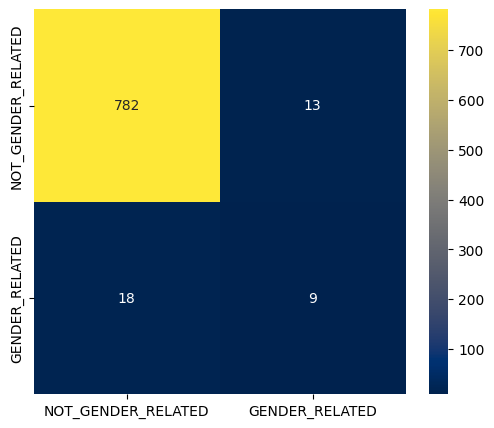

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_label_df, preds)
df_cm = pd.DataFrame(cm, index = [i for i in ['NOT_GENDER_RELATED', 'GENDER_RELATED']],
                    columns = [i for i in ['NOT_GENDER_RELATED', 'GENDER_RELATED']])
plt.figure(figsize=(6,5))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='cividis')
print('Confusion matrix for DistilRoBERTa')
plt.show()

AUC for DistilRoBERTa0.: 0.6584905660377358


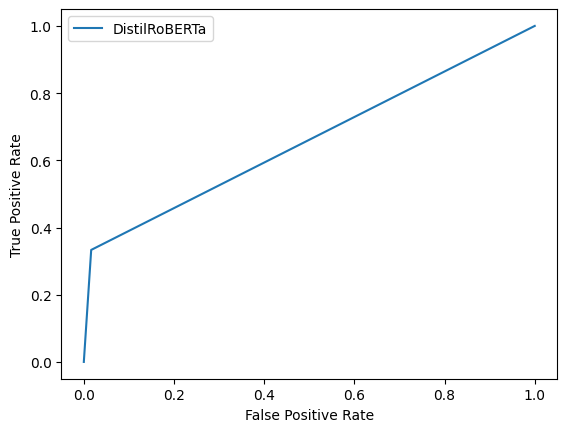

In [31]:
from sklearn.metrics import roc_auc_score

auc_llama = roc_auc_score(true_label_df, preds)
print("AUC for DistilRoBERTa0.:", auc_llama)

#plot ROC curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(true_label_df, preds, pos_label=1)
plt.plot(fpr, tpr, label='DistilRoBERTa')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()